In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Standard imports

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt
import os, json, csv, datetime, sys, collections, traceback, textwrap
from pprint import pprint
import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm
sys.path.append('../src/')
PROJECT_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
PROJECT_DIR

'/home/rutuja.gurav/ligo_gwsearch_with_glitches'

## LIGO data wrangling imports

In [13]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
from gwpy.timeseries import TimeSeries, TimeSeriesDict, TimeSeriesList, StateTimeSeries
from gwpy.segments import DataQualityFlag, DataQualityDict
from gwpy.table import EventTable
from gwpy.plot import Plot
from gwpy.time import to_gps, from_gps

# Load the events catalogs

In [14]:
gwtc_catalog = EventTable.fetch_open_data("GWTC").to_pandas().sort_values(by="network_matched_filter_snr", ascending=False)
gwtc_catalog

GPS chirp_mass_source mass_1_source chi_eff  \
name                                                                       
GW170817-v3         1.187009e+09             1.186          1.46     0.0   
GW200129_065458-v1  1.264316e+09              27.2          34.5    0.11   
GW150914-v3         1.126259e+09              28.6          35.6   -0.01   
GW190521_074359-v2  1.242460e+09              32.8          43.4     0.1   
GW190814_211039-v3  1.249852e+09              6.11          23.3     0.0   
...                          ...               ...           ...     ...   
GW190403_051519-v1  1.238304e+09              34.0          85.0    0.68   
GW200208_222617-v1  1.265236e+09              19.8          51.0    0.45   
GW200220_061928-v1  1.266215e+09              62.0          87.0    0.06   
GW200308_173609-v1  1.267724e+09              34.0          60.0    0.16   
GW200322_091133-v1  1.268904e+09              15.0          38.0    0.27   

                   chirp_mass_upper total_mass_source_lower  \
name                                                          
GW170817-v3                    None                    None   
GW200129_065458-v1             None                    -3.4   
GW150914-v3                    None                    None   
GW190521_074359-v2             None                    -5.9   
GW190814_211039-v3             None                    -1.3   
...                             ...                     ...   
GW190403_051519-v1             None                   -23.6   
GW200208_222617-v1             None                   -26.0   
GW200220_061928-v1             None                   -33.0   
GW200308_173609-v1             None                   -48.0   
GW200322_091133-v1             None                   -22.0   

                   network_matched_filter_snr_lower mass_2_source_upper  \
name                                                                      
GW170817-v3                                    None                0.09   
GW200129_065458-v1                             -0.2                 3.3   
GW150914-v3                                    -0.2                 3.0   
GW190521_074359-v2                             -0.2                 5.2   
GW190814_211039-v3                             -0.2                 0.1   
...                                             ...                 ...   
GW190403_051519-v1                             -1.1                26.3   
GW200208_222617-v1                             -1.2                 9.2   
GW200220_061928-v1                             -0.7                26.0   
GW200308_173609-v1                             -2.9                36.0   
GW200322_091133-v1                             -3.0                24.3   

                   mass_2_source luminosity_distance_lower  ...  \
name                                                        ...   
GW170817-v3                 1.27                     -15.0  ...   
GW200129_065458-v1          29.0                    -370.0  ...   
GW150914-v3                 30.6                    -170.0  ...   
GW190521_074359-v2          33.4                    -530.0  ...   
GW190814_211039-v3           2.6                     -50.0  ...   
...                          ...                       ...  ...   
GW190403_051519-v1          20.0                   -4290.0  ...   
GW200208_222617-v1          12.3                   -2000.0  ...   
GW200220_061928-v1          61.0                   -3100.0  ...   
GW200308_173609-v1          24.0                   -4400.0  ...   
GW200322_091133-v1          11.3                   -2200.0  ...   

                   luminosity_distance_upper final_mass_source_lower  \
name                                                                   
GW170817-v3                              7.0                    None   
GW200129_065458-v1                     260.0                    -3.2   
GW150914-v3                            150.0                    -3.0   
GW190521_074

# Collect events data from H1 and L1 detectors.

In [114]:
from preprocess import preprocess_ts, znorm_ts
bandpass_freq=(30, 350)
notch_freqs = (36,41,60,120,180,332)
taper_nsamples = int(6*4096*0.1)
events_dataset = {}
for i, (index, event) in tqdm(enumerate(gwtc_catalog.iterrows())):
    # if event['commonName'] == 'GW170817': continue
    event_gps = event['GPS']
    try: 
        hdata_raw = TimeSeries.fetch_open_data('H1', event_gps-6, event_gps+6)
        ldata_raw = TimeSeries.fetch_open_data('L1', event_gps-6, event_gps+6)
        # print(hdata.value.shape, ldata.value.shape)
        
        hdata = znorm_ts(hdata_raw)
        ldata = znorm_ts(ldata_raw)
        # print(hdata.value.shape, ldata.value.shape)

        ## bandpass the data to 30-350 Hz and notch at 60, 120, 180 Hz to take out the AC power line noise.
        hdata_bandpassed = preprocess_ts(hdata, bandpass_freq=bandpass_freq, notch_freqs=notch_freqs)
        ldata_bandpassed = preprocess_ts(ldata, bandpass_freq=bandpass_freq, notch_freqs=notch_freqs)
        # print(hdata.value.shape, ldata.value.shape)
        
        # ## whiten the data
        # hdata_whitened = hdata.whiten().crop(*hdata.span.contract(1))
        # ldata_whitened = ldata.whiten().crop(*ldata.span.contract(1))
        # # print(hdata.value.shape, ldata.value.shape)

        # hdata_whitened_bandpassed = preprocess_ts(hdata_whitened, bandpass_freq=bandpass_freq, notch_freqs=notch_freqs)
        # ldata_whitened_bandpassed = preprocess_ts(ldata_whitened, bandpass_freq=bandpass_freq, notch_freqs=notch_freqs)
        # # print(hdata.value.shape, ldata.value.shape)

        ## take off 2 seconds from the beginning and end of the raw data to match length with the shortest processed version of the sample
        hdata = hdata.crop(*hdata.span.contract(2))
        ldata = ldata.crop(*ldata.span.contract(2))

        ## take off 1 more second from the beginning and end of the bandpassed-only and whitened-only data to match length with the shortest processed version of the sample
        hdata_bandpassed = hdata_bandpassed.crop(*hdata_bandpassed.span.contract(1))
        ldata_bandpassed = ldata_bandpassed.crop(*ldata_bandpassed.span.contract(1))

        # hdata_whitened = hdata_whitened.crop(*hdata_whitened.span.contract(1))
        # ldata_whitened = ldata_whitened.crop(*ldata_whitened.span.contract(1))

        ## Taper ends
        # hdata = hdata.taper(nsamples=taper_nsamples)
        # ldata = ldata.taper(nsamples=taper_nsamples)
        # hdata_bandpassed = hdata_bandpassed.taper(nsamples=taper_nsamples)
        # ldata_bandpassed = ldata_bandpassed.taper(nsamples=taper_nsamples)
        # hdata_whitened = hdata_whitened.taper(nsamples=taper_nsamples)
        # ldata_whitened = ldata_whitened.taper(nsamples=taper_nsamples)
        # hdata_whitened_bandpassed = hdata_whitened_bandpassed.taper(nsamples=taper_nsamples)
        # ldata_whitened_bandpassed = ldata_whitened_bandpassed.taper(nsamples=taper_nsamples)

        # print(hdata.duration, ldata.duration,
        #     hdata_bandpassed.duration, ldata_bandpassed.duration,
        #     hdata_whitened.duration, ldata_whitened.duration,
        #     hdata_whitened_bandpassed.duration, ldata_whitened_bandpassed.duration)

        events_dataset[event['commonName']] = TimeSeriesDict({  
                                                    'H1_raw': hdata_raw, 'L1_raw': ldata_raw,
                                                    'H1': hdata, 'L1': ldata, 
                                                    'H1_bandpassed': hdata_bandpassed, 'L1_bandpassed': ldata_bandpassed,
                                                    # 'H1_whitened': hdata_whitened, 'L1_whitened': ldata_whitened,
                                                    # 'H1_whitened_bandpassed': hdata_whitened_bandpassed, 'L1_whitened_bandpassed': ldata_whitened_bandpassed
                                                })

    except Exception as e:
        print(e)
        continue

0it [00:00, ?it/s]

Cannot find a GWOSC dataset for H1 covering [1262879930, 1262879942)
Cannot find a GWOSC dataset for L1 covering [1260567230, 1260567243)
Cannot find a GWOSC dataset for H1 covering [1245955937, 1245955950)
Cannot find a GWOSC dataset for H1 covering [1246663509, 1246663522)
Cannot find a GWOSC dataset for H1 covering [1245035073, 1245035086)
Cannot find a GWOSC dataset for L1 covering [1267149503, 1267149516)
Cannot find a GWOSC dataset for H1 covering [1240164420, 1240164433)
Cannot find a GWOSC dataset for L1 covering [1253489337, 1253489350)


# Matrix Profile Analyses

In [115]:
import mp_utils
motif_len = 400
algo = 'scamp'

In [109]:
# from itertools import cycle
# event_names = cycle(list(events_dataset.keys()))
# event_name = next(event_names)

In [116]:
event_name = "GW200129_065458" # "GW150914"
event_name

# event_time = from_gps(1126259447) ## From Nader
# print(event_time)

'GW200129_065458'

### Using z-normalized data samples

Computing the Exact Matrix Profile self-join using SCAMP...
	(timeseries length = 32768, subsequence length = 400)...
DONE.
Time taken: 0:00:00.224973
	min(MP)/mean(MP) = 0.22809237534313764
Computing the Exact Matrix Profile self-join using SCAMP...
	(timeseries length = 32768, subsequence length = 400)...
DONE.
Time taken: 0:00:00.195521
	min(MP)/mean(MP) = 0.3157216936666707
Computing the Exact Matrix Profile AB-join using SCAMP...
	(timeseries length = 32768, subsequence length = 400)...
DONE.
Time taken: 0:00:00.150045
	min(MP)/mean(MP) = 0.3371218733726506



Computing the Exact Matrix Profile self-join using SCAMP...
	(timeseries length = 32768, subsequence length = 400)...
DONE.
Time taken: 0:00:00.211207
	min(MP)/mean(MP) = 0.6165176099866708
Computing the Exact Matrix Profile self-join using SCAMP...
	(timeseries length = 32768, subsequence length = 400)...
DONE.
Time taken: 0:00:00.226447
	min(MP)/mean(MP) = 0.790372989979886
Computing the Exact Matrix Profile AB-join using 

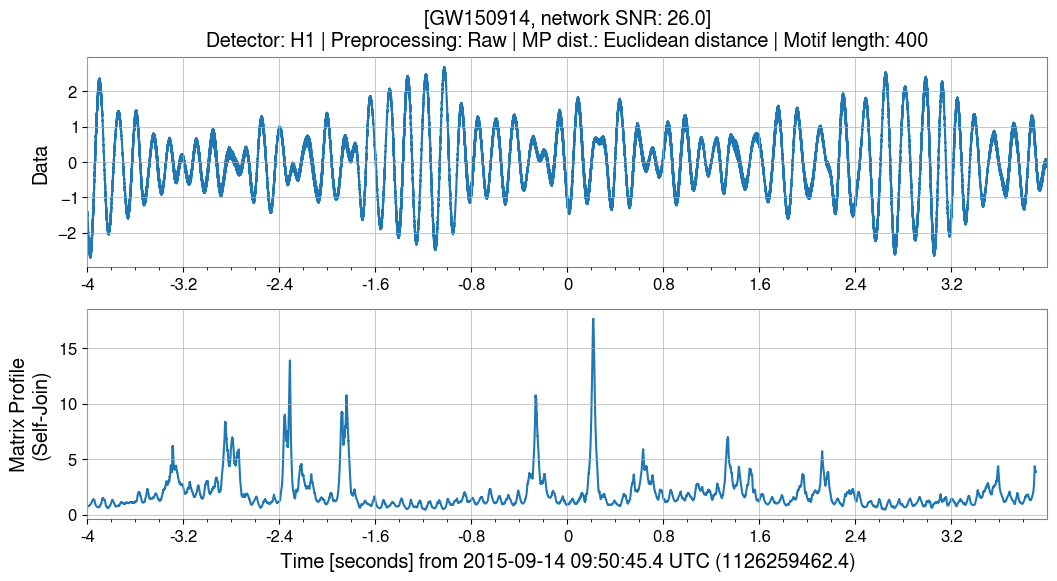

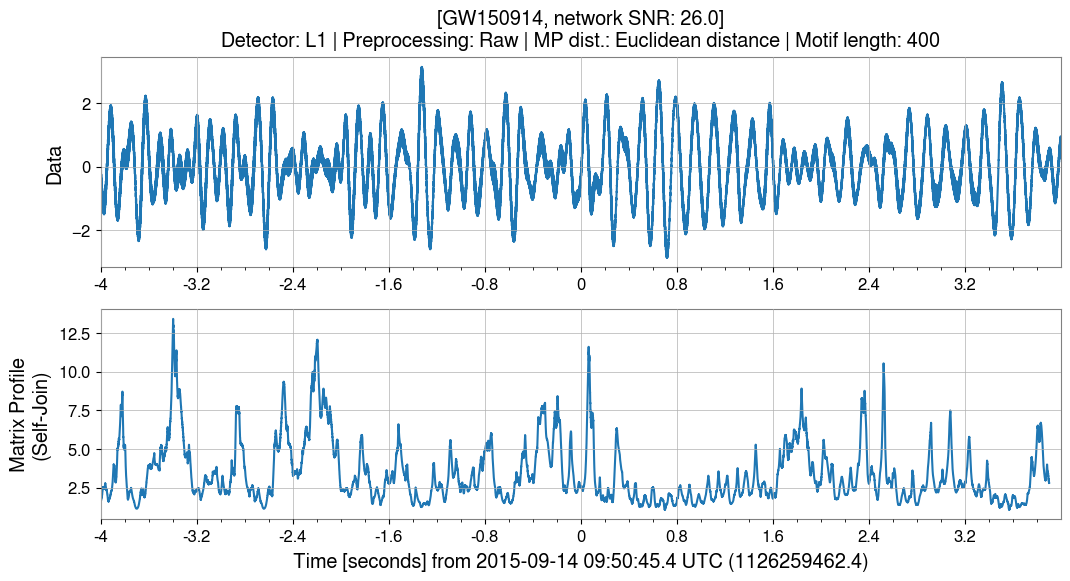

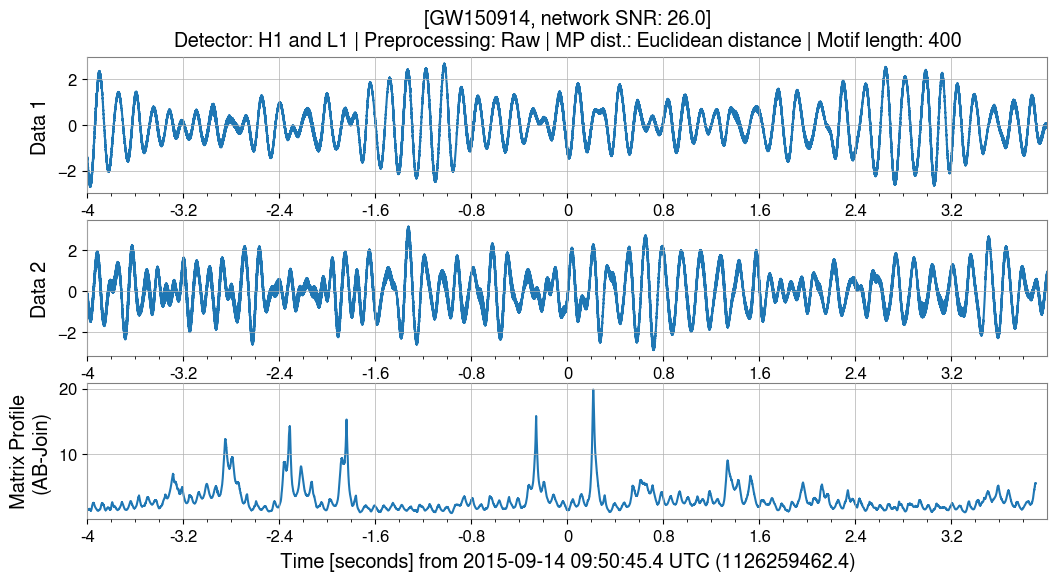

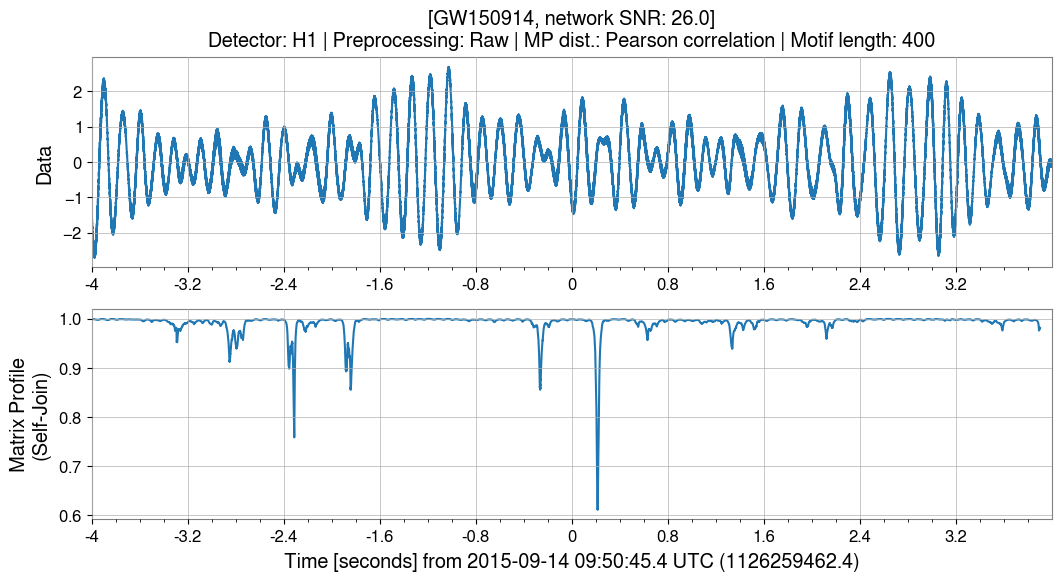

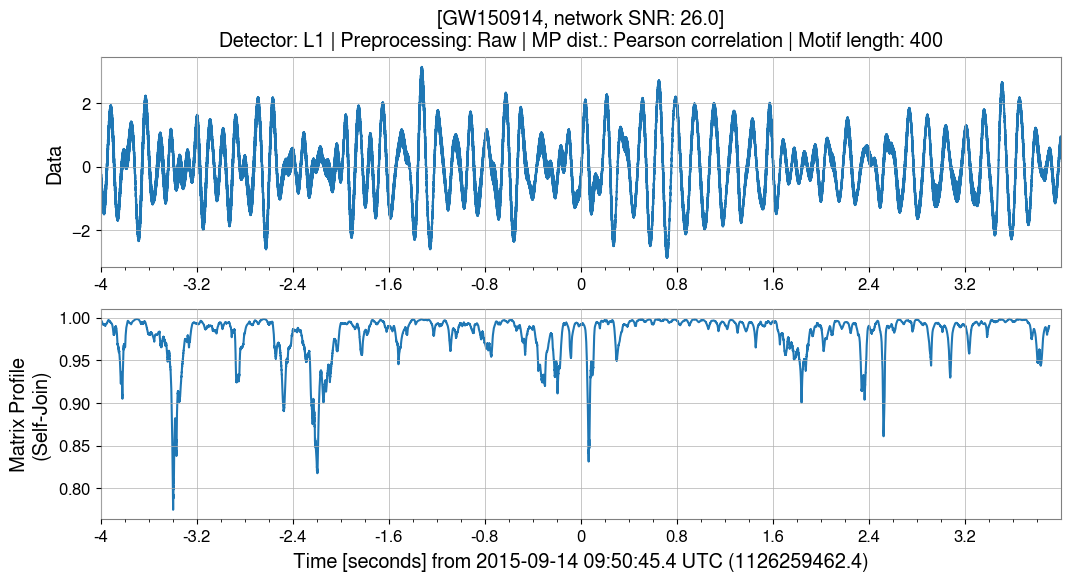

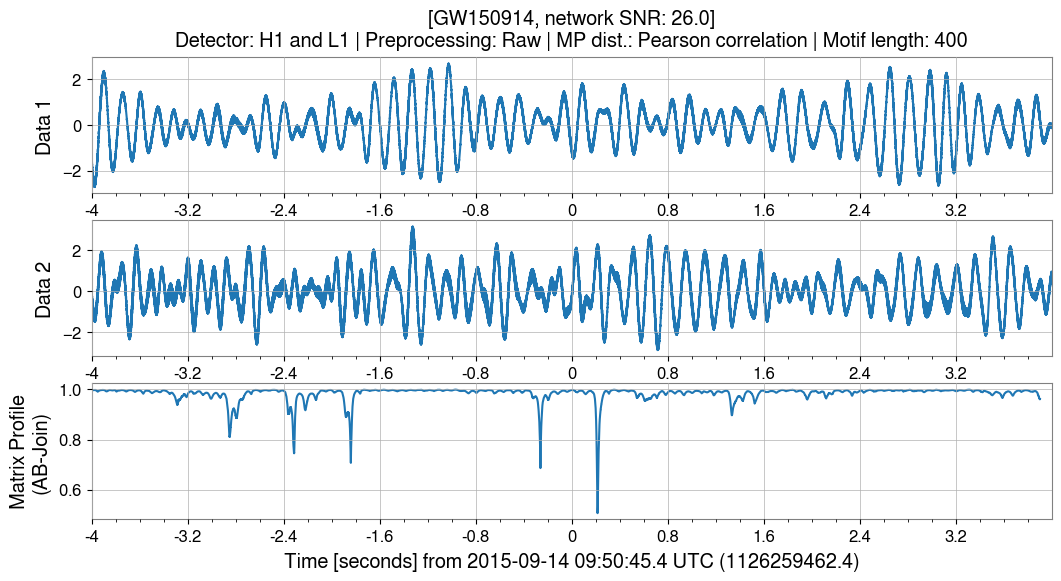

In [111]:
%matplotlib inline

event_data = events_dataset[event_name]
event_gps = gwtc_catalog[gwtc_catalog['commonName'] == event_name]['GPS'].values[0]
event_snr = gwtc_catalog[gwtc_catalog['commonName'] == event_name]['network_matched_filter_snr'].values[0]

## Using raw, z-normalized data
H1_data_ts = event_data['H1']
L1_data_ts = event_data['L1']

### Euclidean distance
H1_data_mp = mp_utils.compute_matrix_profile(H1_data_ts.value, m=motif_len, algo=algo)
L1_data_mp = mp_utils.compute_matrix_profile(L1_data_ts.value, m=motif_len, algo=algo)
H1_L1_data_mp = mp_utils.compute_matrix_profile(H1_data_ts.value, T_B=L1_data_ts.value, m=motif_len, algo=algo)

titlestr = f"Preprocessing: Raw | MP dist.: Euclidean distance | Motif length: {motif_len}"
plot = mp_utils.plot_matrix_profile(H1_data_ts, mp=H1_data_mp, event_gps=event_gps, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: H1 | {titlestr}")
plot = mp_utils.plot_matrix_profile(L1_data_ts, mp=L1_data_mp, event_gps=event_gps, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: L1 | {titlestr}")
plot = mp_utils.plot_matrix_profile([H1_data_ts, L1_data_ts], event_gps=event_gps, mp=H1_L1_data_mp, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: H1 and L1 | {titlestr}")

print("\n\n")
### Pearson correlation
H1_data_mp = mp_utils.compute_matrix_profile(H1_data_ts.value, m=motif_len, algo=algo, compute_correlation=True)
L1_data_mp = mp_utils.compute_matrix_profile(L1_data_ts.value, m=motif_len, algo=algo, compute_correlation=True)
H1_L1_data_mp = mp_utils.compute_matrix_profile(H1_data_ts.value, T_B=L1_data_ts.value, m=motif_len, algo=algo, compute_correlation=True)

titlestr = f"Preprocessing: Raw | MP dist.: Pearson correlation | Motif length: {motif_len}"
plot = mp_utils.plot_matrix_profile(H1_data_ts, mp=H1_data_mp, event_gps=event_gps, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: H1 | {titlestr}")
plot = mp_utils.plot_matrix_profile(L1_data_ts, mp=L1_data_mp, event_gps=event_gps, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: L1 | {titlestr}")
plot = mp_utils.plot_matrix_profile([H1_data_ts, L1_data_ts], event_gps=event_gps, mp=H1_L1_data_mp, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: H1 and L1 | {titlestr}")

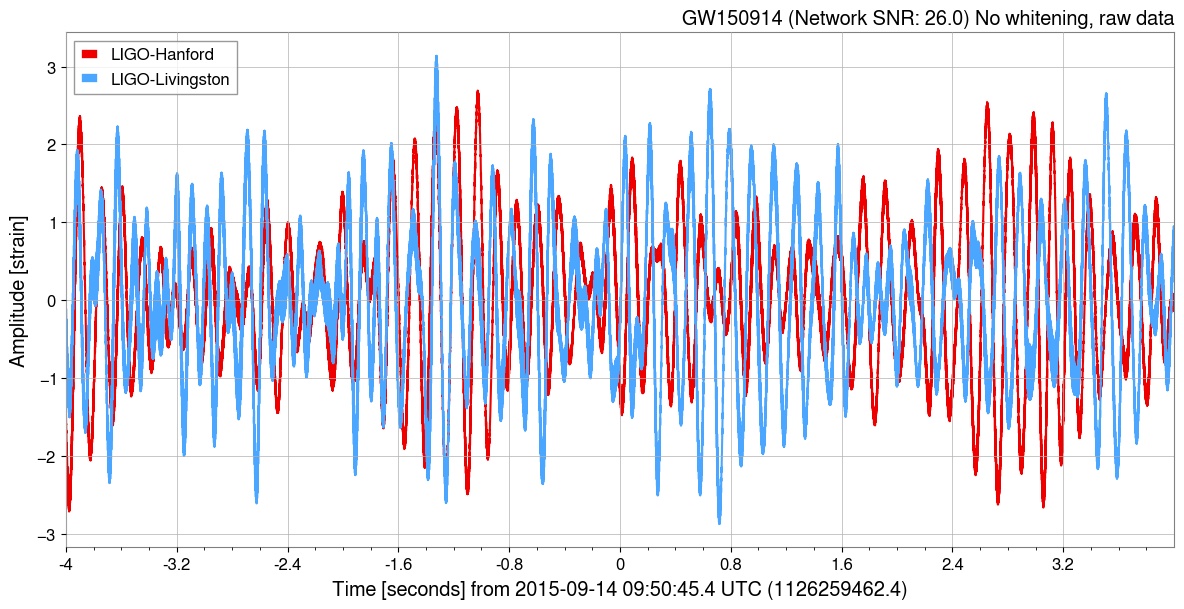

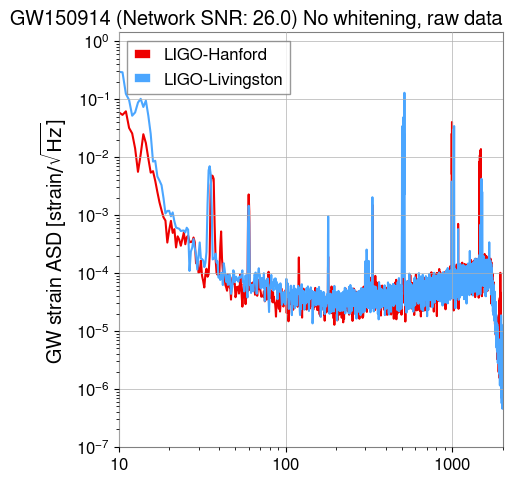

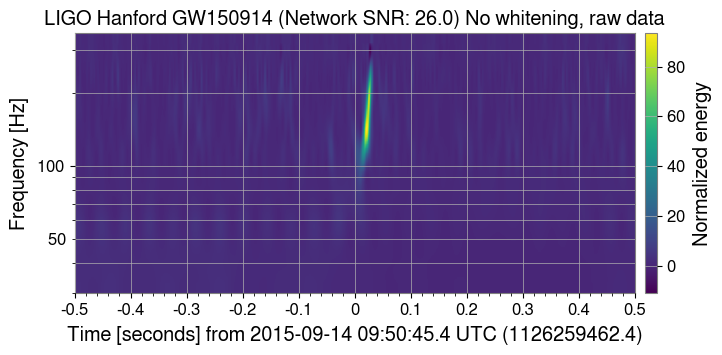

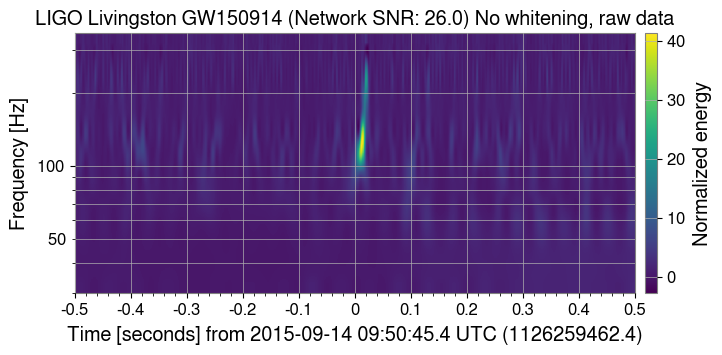

In [112]:
from plotting_utils import plot_event_ts, plot_event_asd, plot_event_qtransform

plot_event_ts(H1_data_ts, L1_data_ts, event_gps=event_gps, titlestr=event_name+f" (Network SNR: {event_snr}) No whitening, raw data")
plot_event_asd(H1_data_ts, L1_data_ts, titlestr=event_name+f" (Network SNR: {event_snr}) No whitening, raw data")
plot_event_qtransform(H1_data_ts, L1_data_ts, event_gps=event_gps, delta_outseg=(0.5,0.5), titlestr=event_name+f" (Network SNR: {event_snr}) No whitening, raw data")


### Using z-normalized,bandpassed,notched version of raw data samples

Computing the Exact Matrix Profile self-join using SCAMP...
	(timeseries length = 32768, subsequence length = 400)...
DONE.
Time taken: 0:00:00.224287
	min(MP)/mean(MP) = 0.8372181250443518
Computing the Exact Matrix Profile self-join using SCAMP...
	(timeseries length = 32768, subsequence length = 400)...
DONE.
Time taken: 0:00:00.204753
	min(MP)/mean(MP) = 0.8490351320566872
Computing the Exact Matrix Profile AB-join using SCAMP...
	(timeseries length = 32768, subsequence length = 400)...
DONE.
Time taken: 0:00:00.151323
	min(MP)/mean(MP) = 0.8162410235702292



Computing the Exact Matrix Profile self-join using SCAMP...
	(timeseries length = 32768, subsequence length = 400)...
DONE.
Time taken: 0:00:00.210993
	min(MP)/mean(MP) = 0.7666357519554967
Computing the Exact Matrix Profile self-join using SCAMP...
	(timeseries length = 32768, subsequence length = 400)...
DONE.
Time taken: 0:00:00.212767
	min(MP)/mean(MP) = 0.7543480338538173
Computing the Exact Matrix Profile AB-join using 

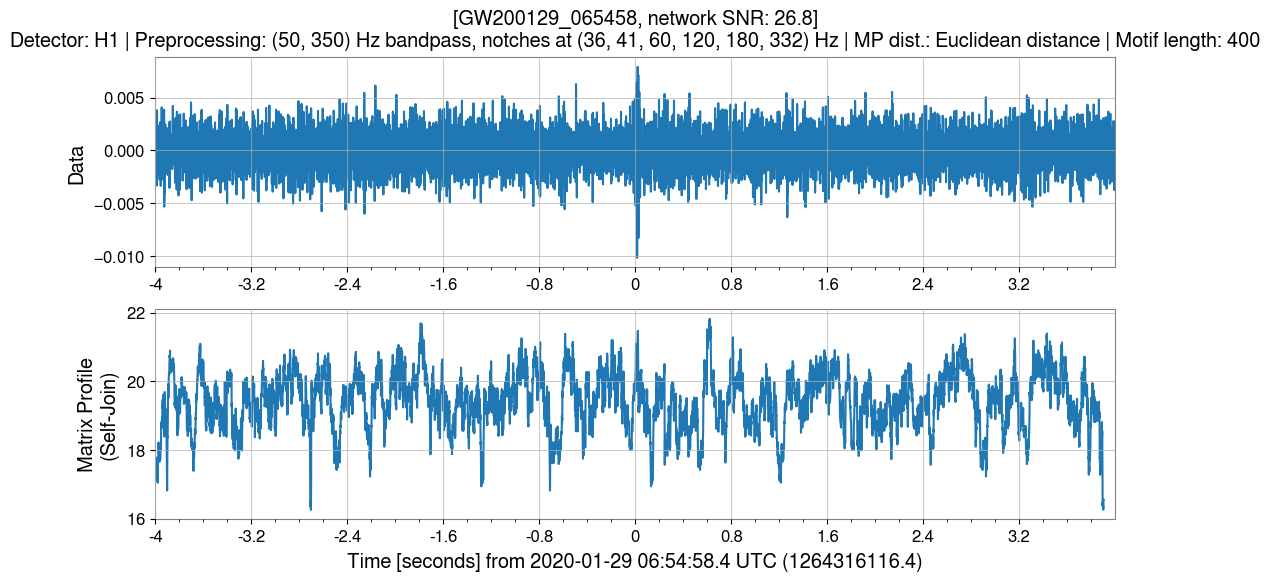

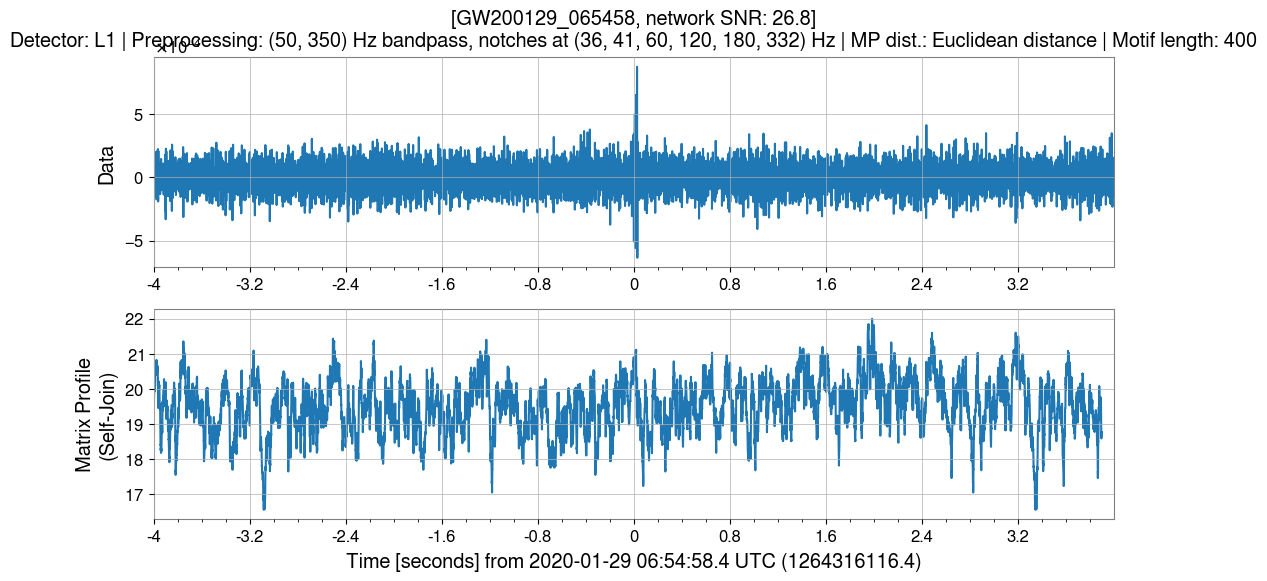

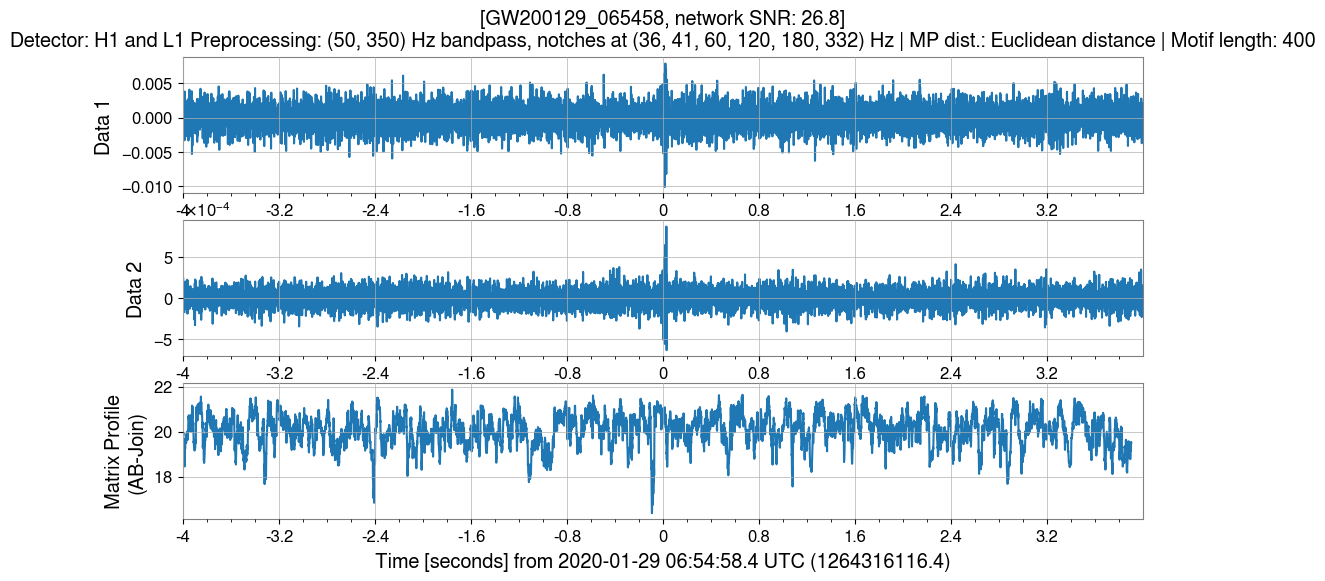

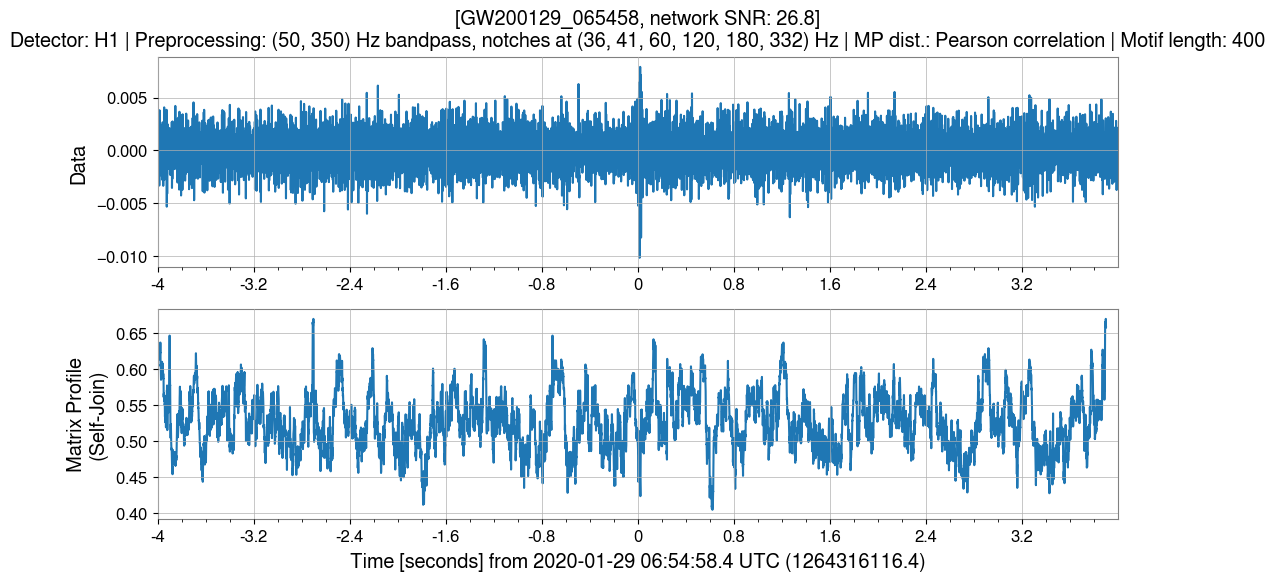

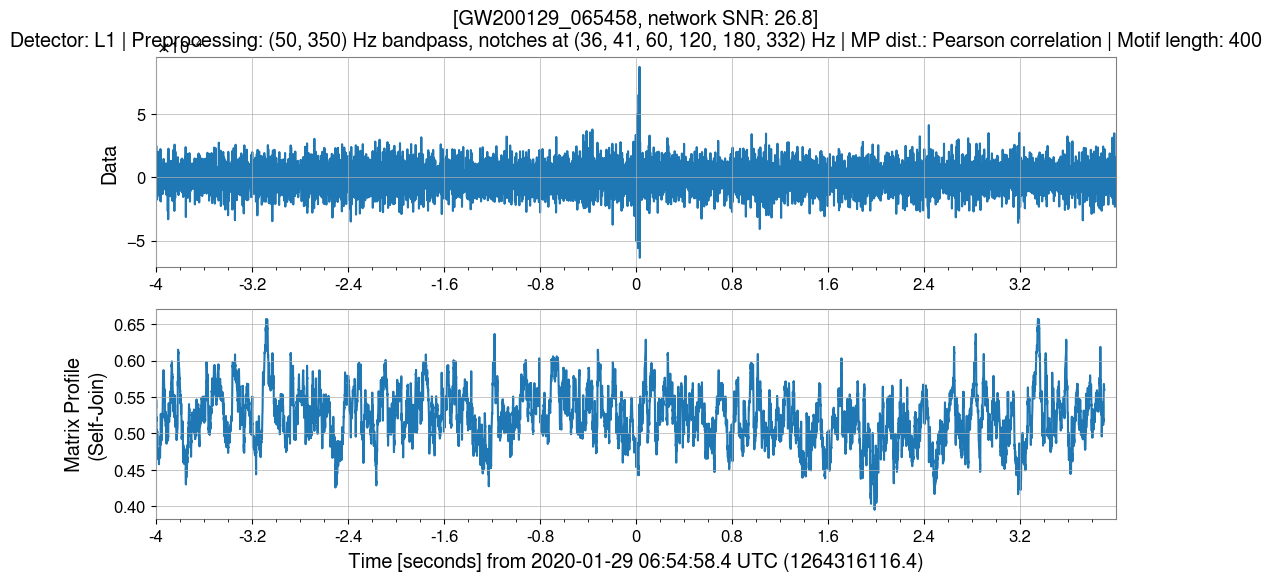

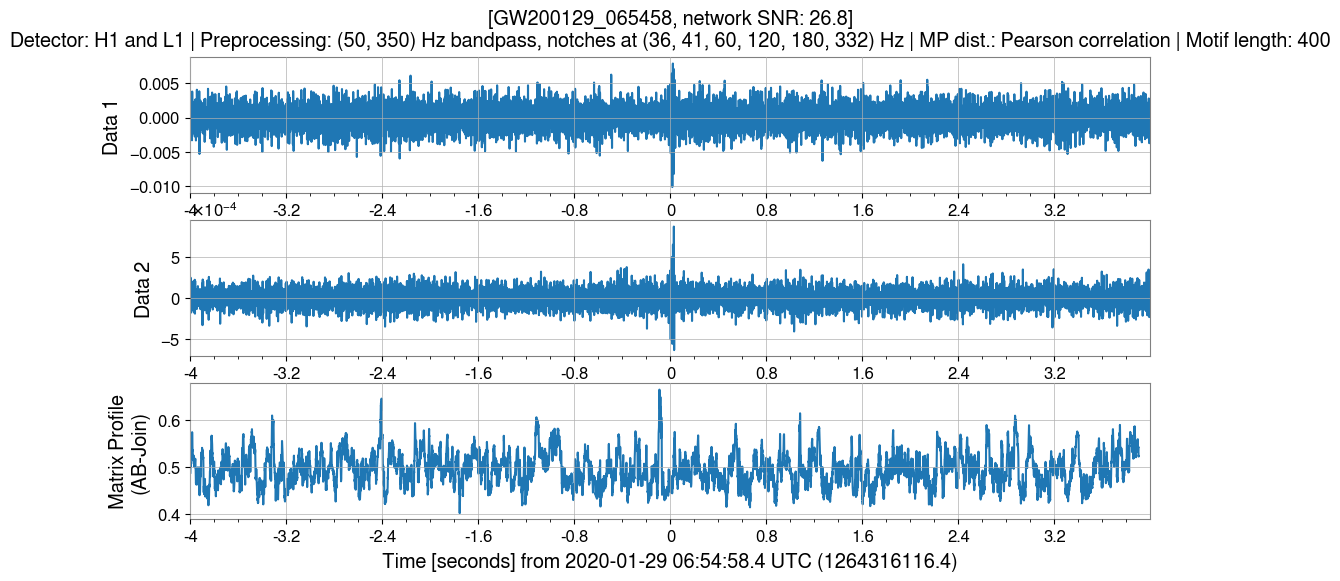

In [117]:
%matplotlib inline
event_data = events_dataset[event_name]
event_gps = gwtc_catalog[gwtc_catalog['commonName'] == event_name]['GPS'].values[0]
event_snr = gwtc_catalog[gwtc_catalog['commonName'] == event_name]['network_matched_filter_snr'].values[0]

## Using bandpassed data
H1_data_ts = event_data['H1_bandpassed']
L1_data_ts = event_data['L1_bandpassed']

### Euclidean distance
H1_data_mp = mp_utils.compute_matrix_profile(H1_data_ts.value, m=motif_len, algo=algo)
L1_data_mp = mp_utils.compute_matrix_profile(L1_data_ts.value, m=motif_len, algo=algo)
H1_L1_data_mp = mp_utils.compute_matrix_profile(H1_data_ts.value, T_B=L1_data_ts.value, m=motif_len, algo=algo)

titlestr = f"Preprocessing: {bandpass_freq} Hz bandpass, notches at {notch_freqs} Hz | MP dist.: Euclidean distance | Motif length: {motif_len}"
plot = mp_utils.plot_matrix_profile(H1_data_ts, mp=H1_data_mp, event_gps=event_gps, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: H1 | {titlestr}")
plot = mp_utils.plot_matrix_profile(L1_data_ts, mp=L1_data_mp, event_gps=event_gps, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: L1 | {titlestr}")
plot = mp_utils.plot_matrix_profile([H1_data_ts, L1_data_ts], event_gps=event_gps, mp=H1_L1_data_mp, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: H1 and L1 {titlestr}")

print("\n\n")
### Pearson correlation
H1_data_mp = mp_utils.compute_matrix_profile(H1_data_ts.value, m=motif_len, algo=algo, compute_correlation=True)
L1_data_mp = mp_utils.compute_matrix_profile(L1_data_ts.value, m=motif_len, algo=algo, compute_correlation=True)
H1_L1_data_mp = mp_utils.compute_matrix_profile(H1_data_ts.value, T_B=L1_data_ts.value, m=motif_len, algo=algo, compute_correlation=True)

titlestr = f"Preprocessing: {bandpass_freq} Hz bandpass, notches at {notch_freqs} Hz | MP dist.: Pearson correlation | Motif length: {motif_len}"
plot = mp_utils.plot_matrix_profile(H1_data_ts, mp=H1_data_mp, event_gps=event_gps, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: H1 | {titlestr}")
plot = mp_utils.plot_matrix_profile(L1_data_ts, mp=L1_data_mp, event_gps=event_gps, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: L1 | {titlestr}")
plot = mp_utils.plot_matrix_profile([H1_data_ts, L1_data_ts], event_gps=event_gps, mp=H1_L1_data_mp, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: H1 and L1 | {titlestr}")    

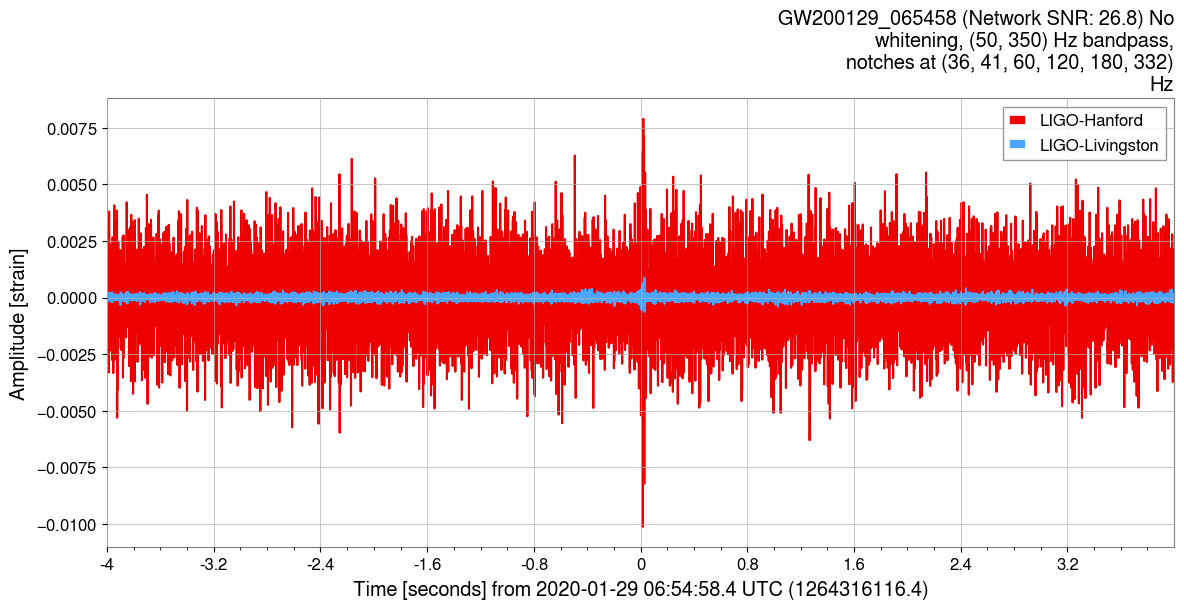

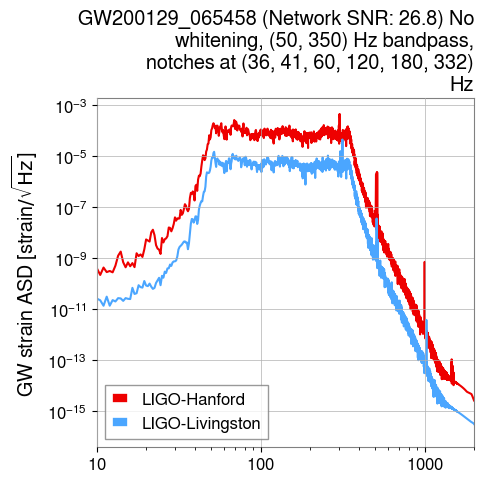

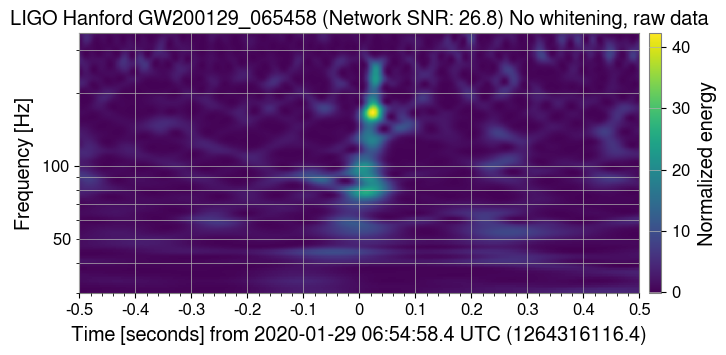

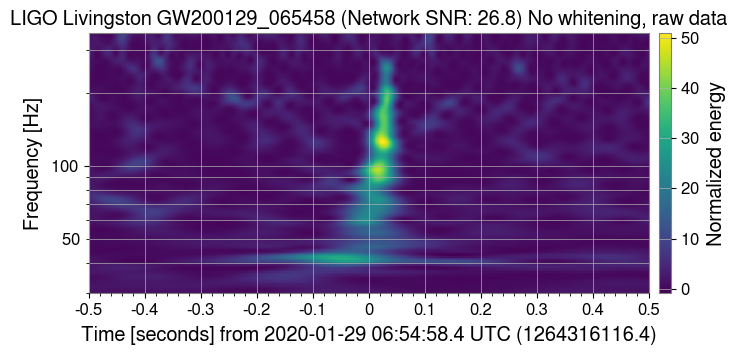

In [118]:
from plotting_utils import plot_event_ts, plot_event_asd, plot_event_qtransform

plot_event_ts(H1_data_ts, L1_data_ts, event_gps=event_gps, 
              titlestr='\n'.join(textwrap.wrap(event_name+f" (Network SNR: {event_snr}) No whitening, {bandpass_freq} Hz bandpass, notches at {notch_freqs} Hz", 40)))
plot_event_asd(H1_data_ts, L1_data_ts, 
               titlestr='\n'.join(textwrap.wrap(event_name+f" (Network SNR: {event_snr}) No whitening, {bandpass_freq} Hz bandpass, notches at {notch_freqs} Hz", 40)))
plot_event_qtransform(H1_data_ts, L1_data_ts, event_gps=event_gps, delta_outseg=(0.5,0.5), titlestr=event_name+f" (Network SNR: {event_snr}) No whitening, raw data")


### Using whitened version of raw data samples

Computing the Exact Matrix Profile self-join using SCAMP...
	(timeseries length = 32768, subsequence length = 400)...
DONE.
Time taken: 0:00:00.145550
Computing the Exact Matrix Profile self-join using SCAMP...
	(timeseries length = 32768, subsequence length = 400)...
DONE.
Time taken: 0:00:00.209399
Computing the Exact Matrix Profile AB-join using SCAMP...
	(timeseries length = 32768, subsequence length = 400)...
DONE.
Time taken: 0:00:00.097988
Computing the Exact Matrix Profile self-join using SCAMP...
	(timeseries length = 32768, subsequence length = 400)...
DONE.
Time taken: 0:00:00.160326
Computing the Exact Matrix Profile self-join using SCAMP...
	(timeseries length = 32768, subsequence length = 400)...
DONE.
Time taken: 0:00:00.122502
Computing the Exact Matrix Profile AB-join using SCAMP...
	(timeseries length = 32768, subsequence length = 400)...
DONE.
Time taken: 0:00:00.136040


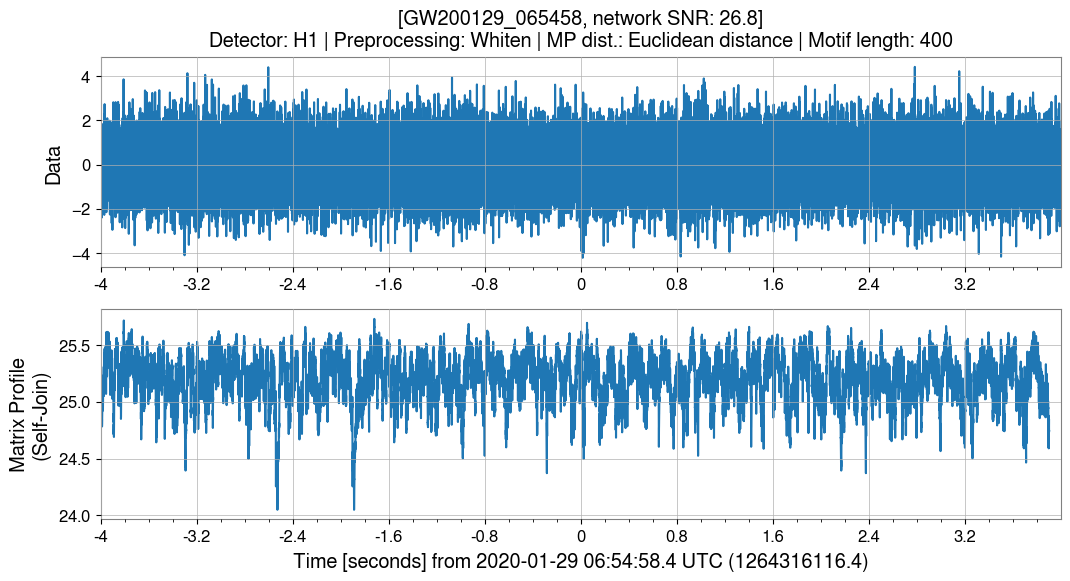

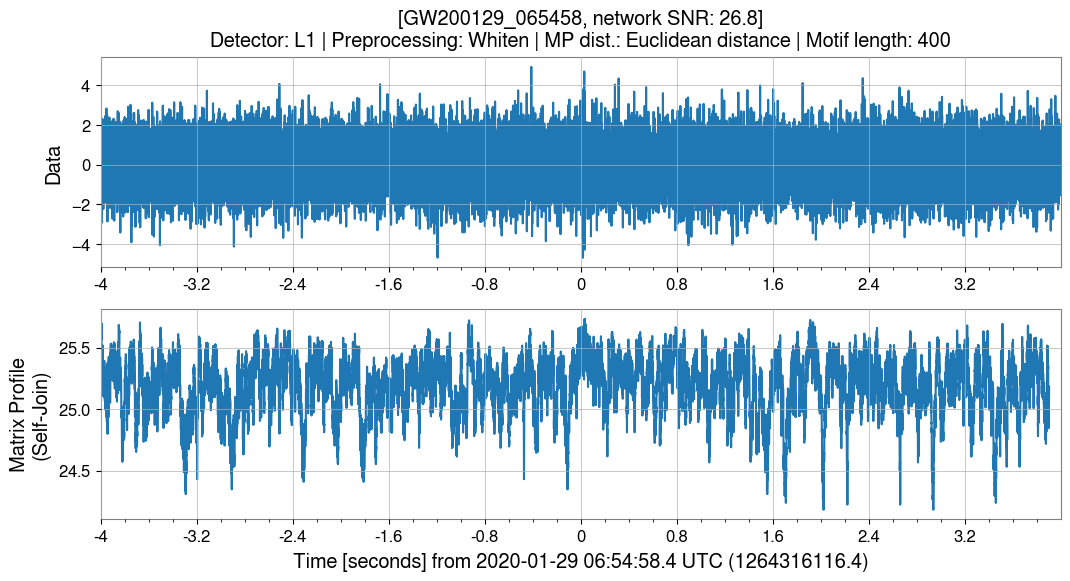

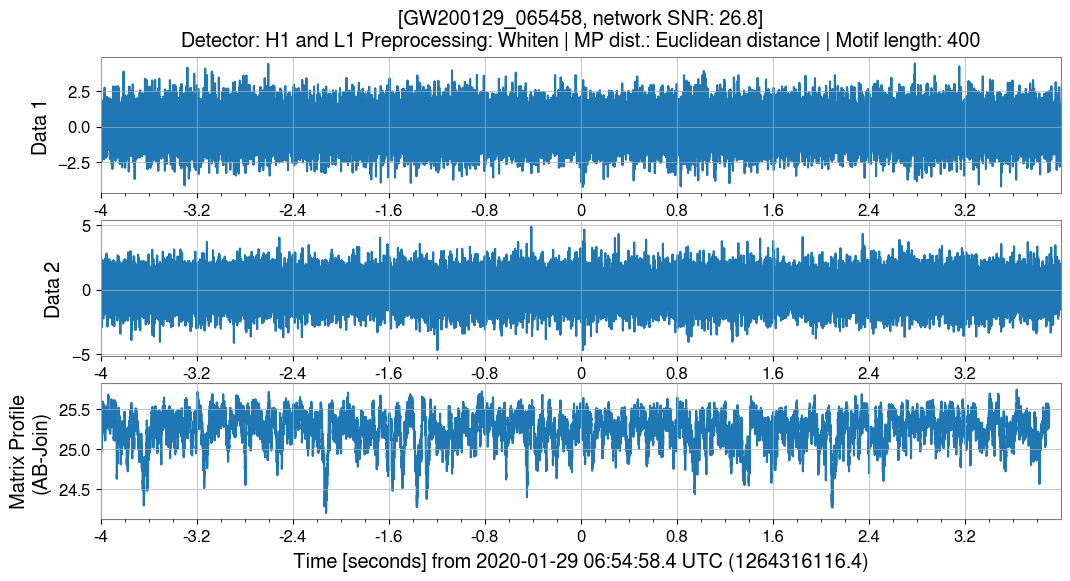

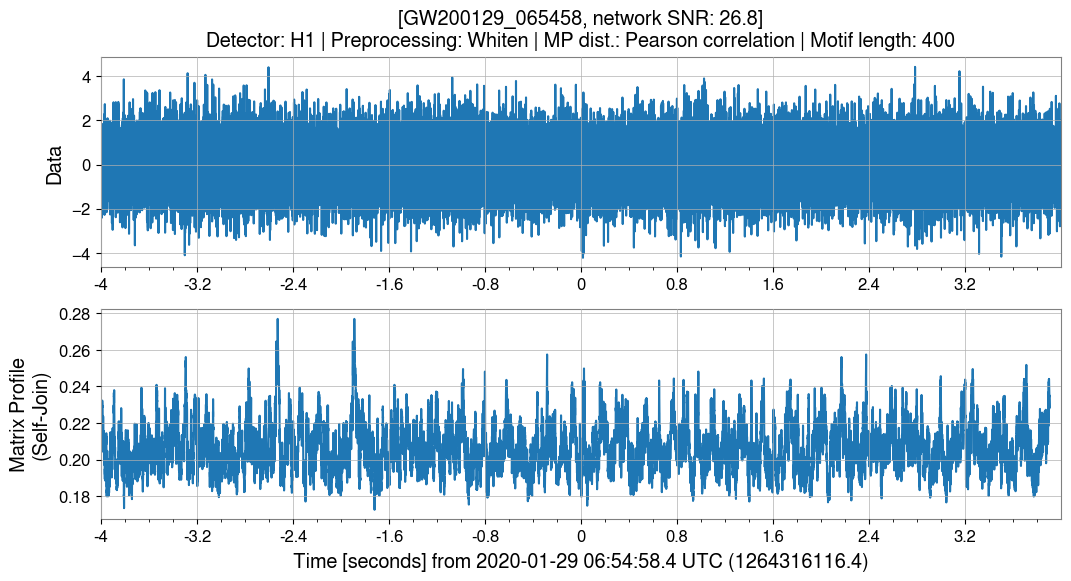

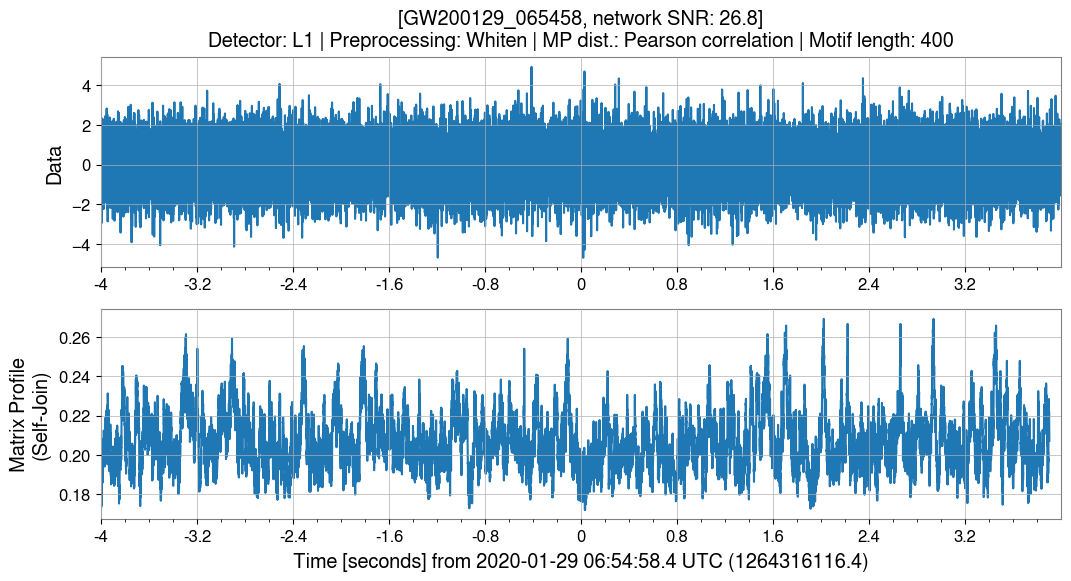

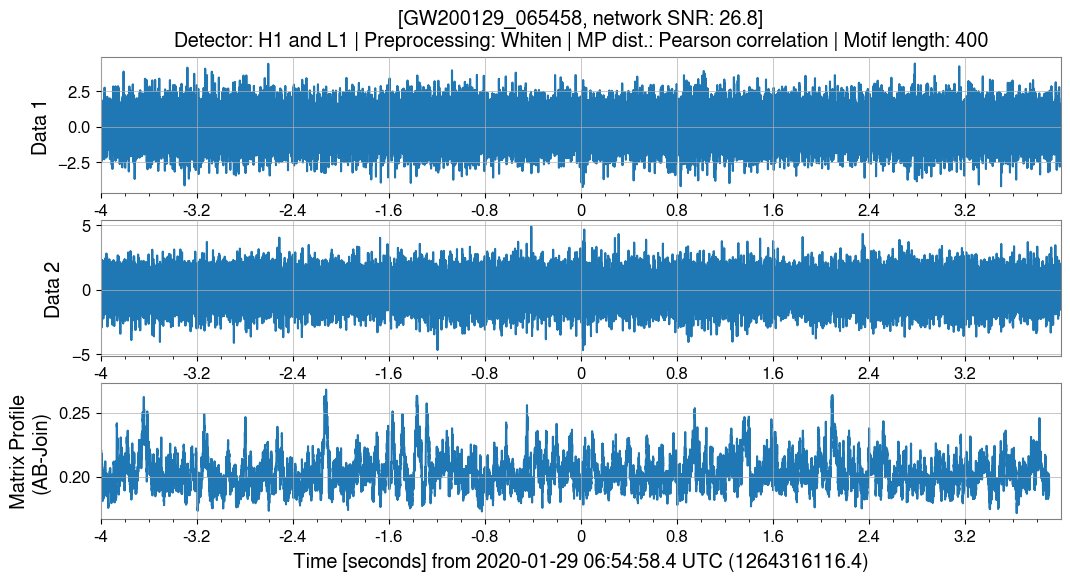

In [131]:
%matplotlib inline
    
event_data = events_dataset[event_name]
event_gps = gwtc_catalog[gwtc_catalog['commonName'] == event_name]['GPS'].values[0]
event_snr = gwtc_catalog[gwtc_catalog['commonName'] == event_name]['network_matched_filter_snr'].values[0]

## Using raw, z-normalized data
H1_data_ts = event_data['H1_whitened']
L1_data_ts = event_data['L1_whitened']

### Euclidean distance
H1_data_mp = mp_utils.compute_matrix_profile(H1_data_ts.value, m=motif_len, algo=algo)
L1_data_mp = mp_utils.compute_matrix_profile(L1_data_ts.value, m=motif_len, algo=algo)
H1_L1_data_mp = mp_utils.compute_matrix_profile(H1_data_ts.value, T_B=L1_data_ts.value, m=motif_len, algo=algo)

titlestr = f"Preprocessing: Whiten | MP dist.: Euclidean distance | Motif length: {motif_len}"
plot = mp_utils.plot_matrix_profile(H1_data_ts, mp=H1_data_mp, event_gps=event_gps, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: H1 | {titlestr}")
plot = mp_utils.plot_matrix_profile(L1_data_ts, mp=L1_data_mp, event_gps=event_gps, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: L1 | {titlestr}")
plot = mp_utils.plot_matrix_profile([H1_data_ts, L1_data_ts], event_gps=event_gps, mp=H1_L1_data_mp, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: H1 and L1 {titlestr}")

### Pearson correlation
H1_data_mp = mp_utils.compute_matrix_profile(H1_data_ts.value, m=motif_len, algo=algo, compute_correlation=True)
L1_data_mp = mp_utils.compute_matrix_profile(L1_data_ts.value, m=motif_len, algo=algo, compute_correlation=True)
H1_L1_data_mp = mp_utils.compute_matrix_profile(H1_data_ts.value, T_B=L1_data_ts.value, m=motif_len, algo=algo, compute_correlation=True)

titlestr = f"Preprocessing: Whiten | MP dist.: Pearson correlation | Motif length: {motif_len}"
plot = mp_utils.plot_matrix_profile(H1_data_ts, mp=H1_data_mp, event_gps=event_gps, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: H1 | {titlestr}")
plot = mp_utils.plot_matrix_profile(L1_data_ts, mp=L1_data_mp, event_gps=event_gps, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: L1 | {titlestr}")
plot = mp_utils.plot_matrix_profile([H1_data_ts, L1_data_ts], event_gps=event_gps, mp=H1_L1_data_mp, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: H1 and L1 | {titlestr}")

### Using whitened then bandpassed+notched version of the raw data sample

Computing the Exact Matrix Profile self-join using SCAMP...
	(timeseries length = 24576, subsequence length = 400)...
DONE.
Time taken: 0:00:00.149316
Computing the Exact Matrix Profile self-join using SCAMP...
	(timeseries length = 24576, subsequence length = 400)...
DONE.
Time taken: 0:00:00.150733
Computing the Exact Matrix Profile AB-join using SCAMP...
	(timeseries length = 24576, subsequence length = 400)...
DONE.
Time taken: 0:00:00.084449
Computing the Exact Matrix Profile self-join using SCAMP...
	(timeseries length = 24576, subsequence length = 400)...
DONE.
Time taken: 0:00:00.157815
Computing the Exact Matrix Profile self-join using SCAMP...
	(timeseries length = 24576, subsequence length = 400)...
DONE.
Time taken: 0:00:00.131400
Computing the Exact Matrix Profile AB-join using SCAMP...
	(timeseries length = 24576, subsequence length = 400)...
DONE.
Time taken: 0:00:00.108408


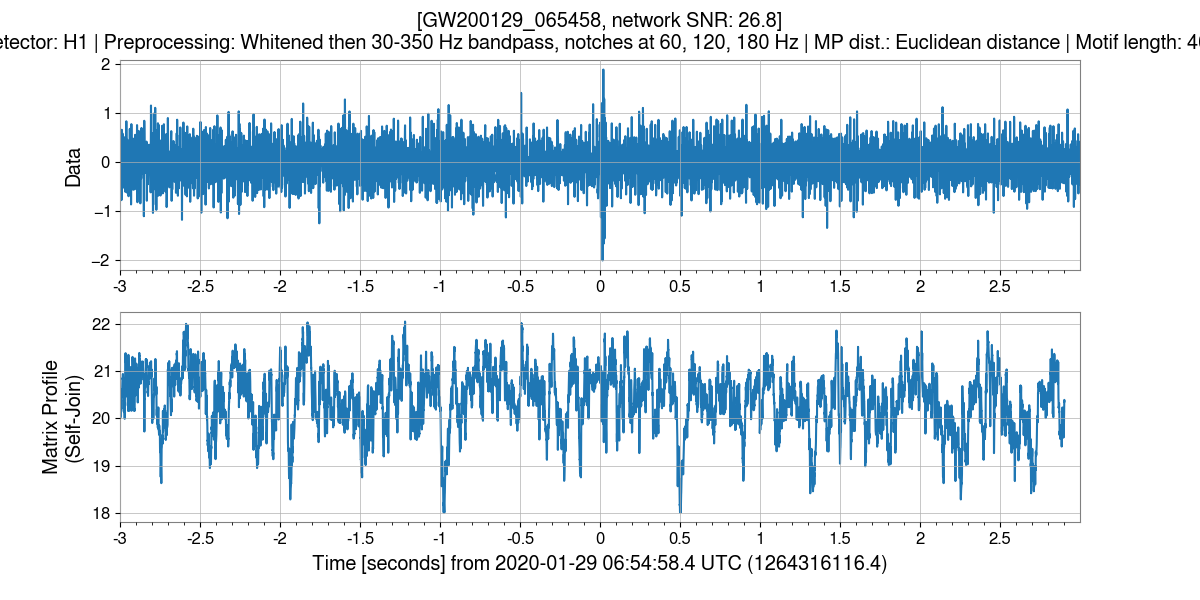

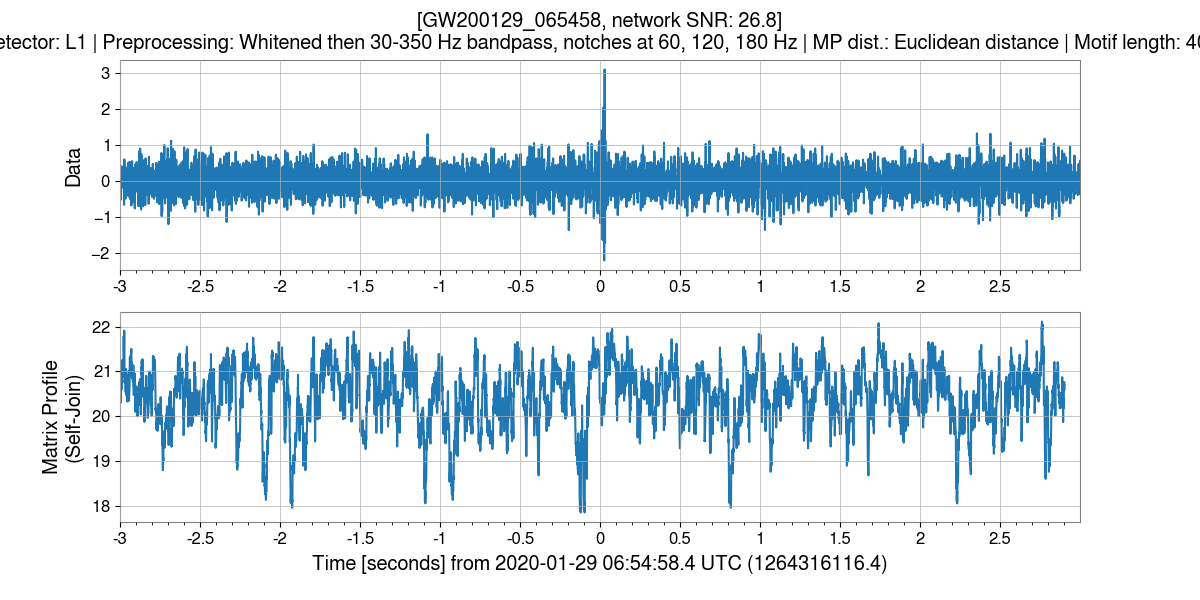

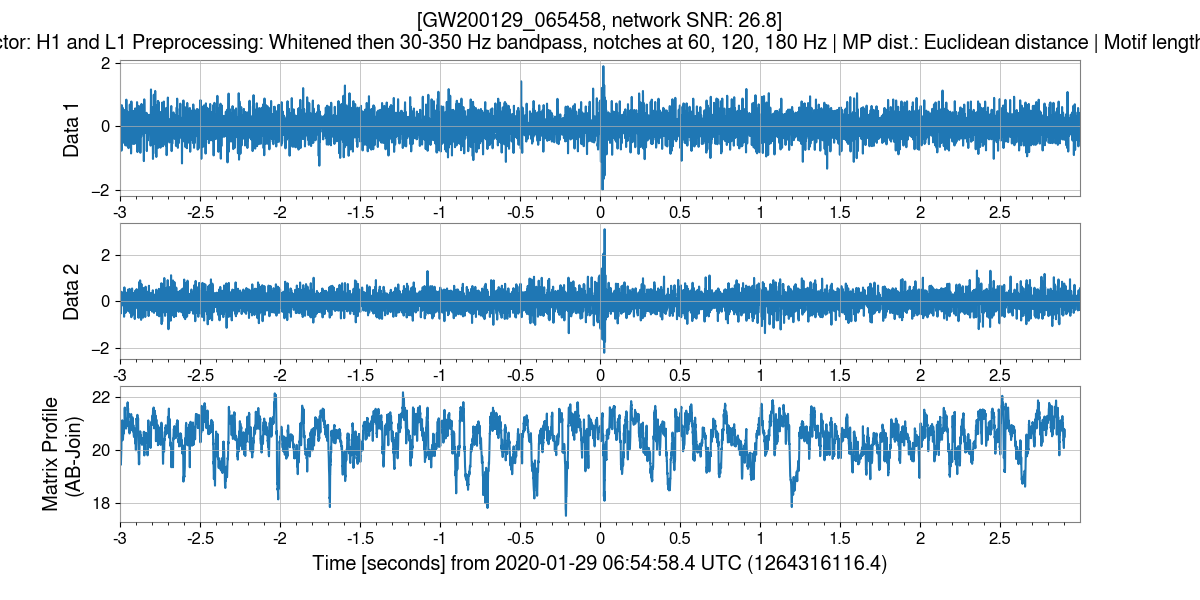

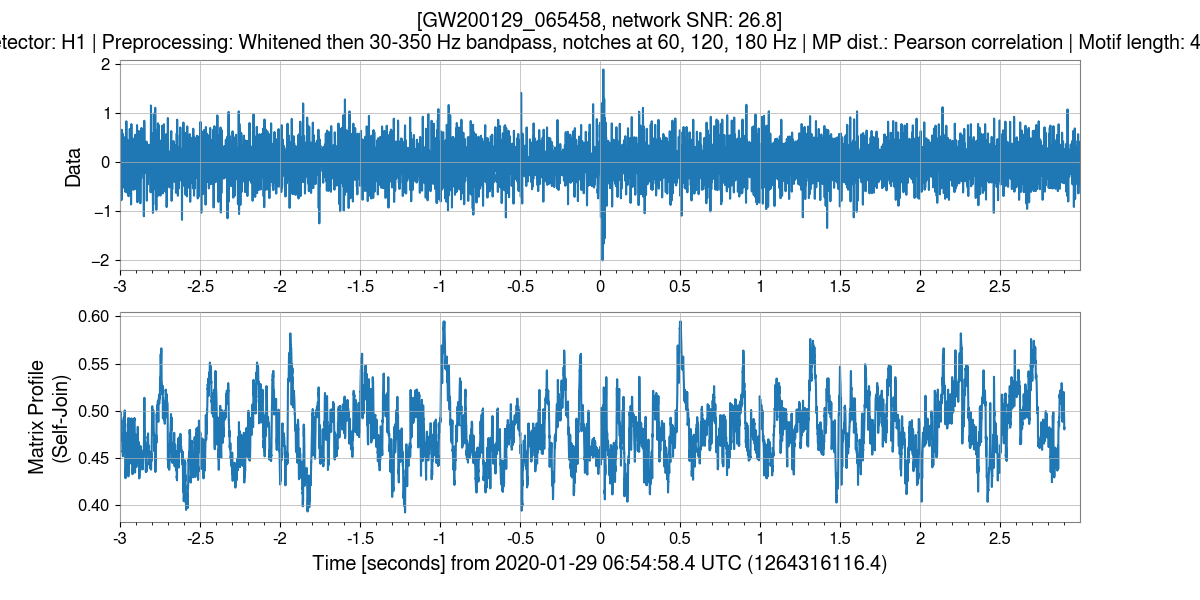

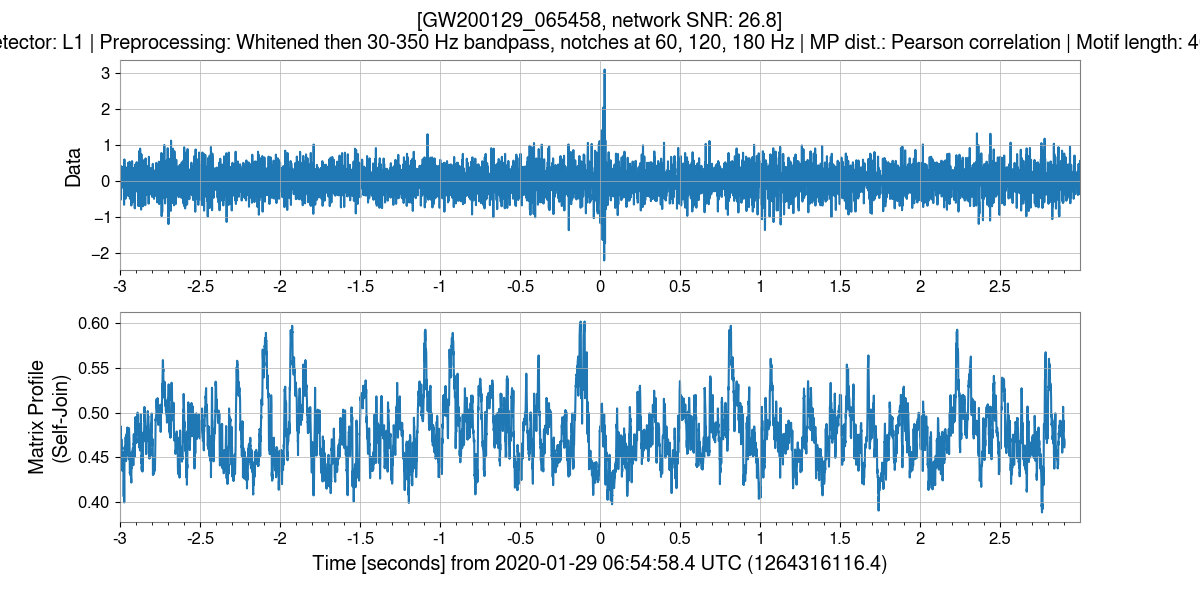

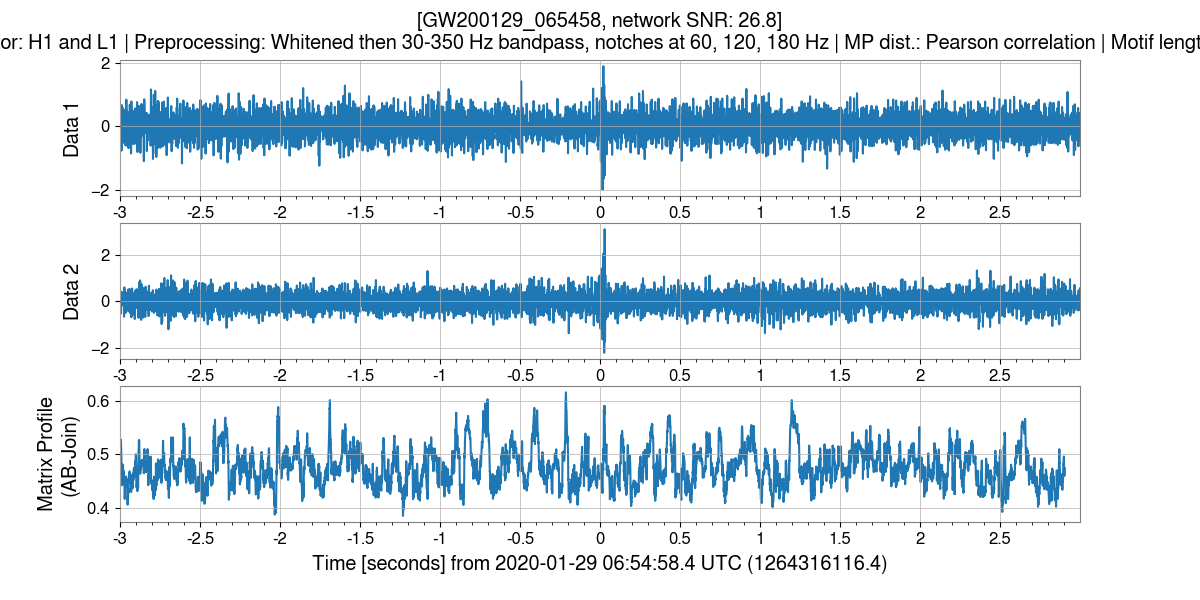

In [12]:
%matplotlib widget

event_data = events_dataset[event_name]
event_gps = gwtc_catalog[gwtc_catalog['commonName'] == event_name]['GPS'].values[0]
event_snr = gwtc_catalog[gwtc_catalog['commonName'] == event_name]['network_matched_filter_snr'].values[0]

## Using raw, z-normalized data
H1_data_ts = event_data['H1_whitened_bandpassed']
L1_data_ts = event_data['L1_whitened_bandpassed']

### Euclidean distance
H1_data_mp = mp_utils.compute_matrix_profile(H1_data_ts.value, m=motif_len, algo=algo)
L1_data_mp = mp_utils.compute_matrix_profile(L1_data_ts.value, m=motif_len, algo=algo)
H1_L1_data_mp = mp_utils.compute_matrix_profile(H1_data_ts.value, T_B=L1_data_ts.value, m=motif_len, algo=algo)

titlestr = f"Preprocessing: Whitened then 30-350 Hz bandpass, notches at 60, 120, 180 Hz | MP dist.: Euclidean distance | Motif length: {motif_len}"
plot = mp_utils.plot_matrix_profile(H1_data_ts, mp=H1_data_mp, event_gps=event_gps, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: H1 | {titlestr}")
plot = mp_utils.plot_matrix_profile(L1_data_ts, mp=L1_data_mp, event_gps=event_gps, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: L1 | {titlestr}")
plot = mp_utils.plot_matrix_profile([H1_data_ts, L1_data_ts], event_gps=event_gps, mp=H1_L1_data_mp, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: H1 and L1 {titlestr}")

### Pearson correlation
H1_data_mp = mp_utils.compute_matrix_profile(H1_data_ts.value, m=motif_len, algo=algo, compute_correlation=True)
L1_data_mp = mp_utils.compute_matrix_profile(L1_data_ts.value, m=motif_len, algo=algo, compute_correlation=True)
H1_L1_data_mp = mp_utils.compute_matrix_profile(H1_data_ts.value, T_B=L1_data_ts.value, m=motif_len, algo=algo, compute_correlation=True)

titlestr = f"Preprocessing: Whitened then 30-350 Hz bandpass, notches at 60, 120, 180 Hz | MP dist.: Pearson correlation | Motif length: {motif_len}"
plot = mp_utils.plot_matrix_profile(H1_data_ts, mp=H1_data_mp, event_gps=event_gps, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: H1 | {titlestr}")
plot = mp_utils.plot_matrix_profile(L1_data_ts, mp=L1_data_mp, event_gps=event_gps, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: L1 | {titlestr}")
plot = mp_utils.plot_matrix_profile([H1_data_ts, L1_data_ts], event_gps=event_gps, mp=H1_L1_data_mp, titlestr=f"[{event_name}, network SNR: {event_snr}]\nDetector: H1 and L1 | {titlestr}")